Deep Learning
=============

Assignment 5
------------

The goal of this assignment is to train a Word2Vec skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

[collections.Counter](http://pymbook.readthedocs.io/en/latest/collections.html) 

[collections.deque](https://pythontips.com/2014/07/02/an-intro-to-deque-module/)

[zipfile](https://docs.python.org/3.3/library/zipfile.html)

Download the data from the source website if necessary.

In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


Read the data into a string.

In [3]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    # f.namelist() return a list of the names of the files in the zip file.
    data = tf.compat.as_str(f.read(f.namelist()[0])).split() # tf.compat.as_str() convert input as a string
    # string.split() return a list of splitted strings by space (not including space)
  return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


Build the dictionary and replace rare words with UNK (unknown) token.

rare words mean the words that don't show up frequently in the dataset. (<50000)

In [4]:
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  # Counter(words).most_common(num) return a list that contains num many tuples that are the most num common vocabulary 
  # in words. The tuples have the structure of ('word',times) 
  dictionary = dict() # empty dictionary; dict is a class in python; dictionary = {}
  for word, _ in count:
    dictionary[word] = len(dictionary)
  # since the words in count are ordered from the most common to the least, the len(dictionary) is the words' rank
  data = list() # data = []
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:  # the words that are not belong to the most 50000 common
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
    # data is a list that maps all the words shown-up times.
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  # dictionary.values() return a seq of values from the dictionary.
  # zip method, see below.
  # reverse_dictionary: the values and keys are reversed.
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5243, 3083, 12, 6, 195, 2, 3134, 46, 59, 156]


[zip() method](https://bradmontgomery.net/blog/pythons-zip-map-and-lambda/): This function takes two equal-length collections, and merges them together in pairs.

Function to generate a training batch for the skip-gram model.

In [5]:
data_index = 0

# big window: skip_window word skip_window
# batch_size:8, the size of batch, batch is a batch of words from which we choose words to train.
# Here we choose batch_size%num_skips many words from 8 words (batch_size).
# num_skips:2(4), one word has num_skips many targets. Or one word would be reused for num_skip times. And batch_size//num_skips should equate 0.  
# skip_window:1(2), the number of words on the left or right of the word. Also skip_window is the index of central word in a big window. 
def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target is at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid: # make sure target is not the central word
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]]) # 8 sequential words in a sentense

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0 # each time generate batch from 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['as', 'anarchism', 'a', 'originated', 'as', 'term', 'of', 'a']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['a', 'originated', 'anarchism', 'term', 'as', 'term', 'of', 'originated']


Train a skip-gram model.

In [6]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left or right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation dataset to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # How many random set of words to evaluate similarity on.
valid_window = 100 # From how many words that validation samples are picked in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample in sampled softmax


# graph: words -> embeddings -> words
# 1st layer: tf.nn.embedding_lookup
# 2nd layer: tf.nn.sampled_softmax_loss
graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  # the rule to map word to embedding vectors is given by tf.embedding_lookup(), and it's a 1to1 rule.
  # but the value of embedding vectors is initialized randomly.
  # tf.random_uniform(shape,minvalue,maxvalue)
  # we have vocabulary_size = 50000 words
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, embed,
                               train_labels, num_sampled, vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  # norm(50000,1)
  normalized_embeddings = embeddings / norm
  # embedding/norm is qual to tf.div, which is element-wise operation
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))
  # valid_embeddings has the 16 words' vectors in embeddings.
  # normalized_embeddings has 50000 words' vectors in embeddings.
  # so the matrix multiplication of similarity is like the inner production of the embedding vectors of 16 words
  # and ones of 50000 words.
  # So it's like find the similarity of the embedding vectors of 16 words from 50000 words.
  # inner product: A.B = |A|*|B|*cos(A,B)

In [7]:
print(similarity.get_shape())
print(valid_embeddings.get_shape())
print(normalized_embeddings.get_shape())
train_dataset
batch_data, batch_labels = generate_batch(batch_size, num_skips, skip_window)
type(batch_data)

(16, 50000)
(16, 128)
(50000, 128)


numpy.ndarray

In [8]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    # batch_data is the ranks, ranks are also considers as the IDs of the words
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      #print(type(sim)) #-> numpy.ndarray
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        # sim[i,:] the similaries of i-th word from the 16 words and every word from 50000 words.
        # argsort() get the sorted ndarray and return the indices
        # [1:top_k+1] avoids the word itself as the highest score
        # indices are the ranks of the frequency in data
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
          # recursively add close_word to log
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 7.912311
Nearest to however: shipwreck, ferus, walks, lakoff, propagate, wim, signature, sap,
Nearest to after: subordinate, embarrassment, supranational, malpractice, permanence, seabirds, arcadius, variste,
Nearest to about: overrun, whimsical, acquires, monorails, cyprian, goldsmiths, suppliers, dominions,
Nearest to they: despotism, durability, entails, basketball, unhappy, usaid, airplay, hummel,
Nearest to not: asserted, qadhafi, herndon, advance, sucker, neberg, limited, rajonas,
Nearest to zero: lata, lumpur, killian, brahmin, agitation, isn, paradiso, unbelief,
Nearest to it: telekom, chrono, neoclassical, hymnody, classicists, lemurs, constructed, gutierrez,
Nearest to i: disadvantageous, songwriting, glick, specialise, colombo, necromancer, gardnerian, winnie,
Nearest to with: finish, bead, cyanides, discussed, mill, dartmouth, nosferatu, prohibitions,
Nearest to only: cheats, bane, handhelds, hurry, claudian, lazuli, emergence, telstra,
N

[Tensorflow Word2vect Tutorial](https://www.tensorflow.org/versions/r0.10/tutorials/word2vec/index.html)

[sklearn.manifold.TSNE](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html#sklearn.manifold.TSNE.fit_transform)

[pyplot](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot)

In [9]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


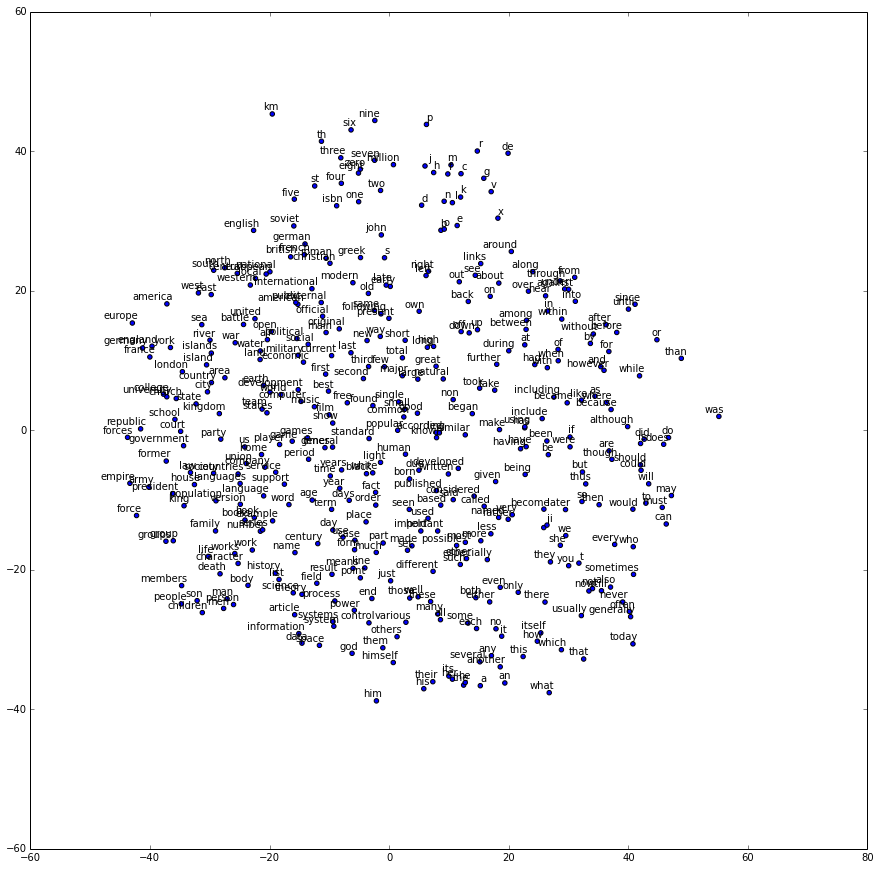

In [10]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

---

Problem
-------

An alternative to skip-gram is another Word2Vec model called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---